### Plotting the impact on P_NL(k,z=0) of the parameters of CWDM. Meant to work with the public CLASS and emulator of Parimbelli et al.

In [7]:
from classy import Class
from matplotlib import pyplot as plt
import numpy as np
import CWDM_interpolator as CWDM
import astropy.units as u
from matplotlib.lines import Line2D
plt.rc('text',usetex=True)
plt.rc('font',size=16,family='serif')

In [8]:
## Global parameters for all plots
z=2
kmax = 100
kk = np.logspace(np.log10(0.001),np.log10(kmax),1000)
omega_dm = 0.1201075
colors = ['blue','red','purple','orange','brown']

## Change to True to print the mass values used during runtime
debug = True

We need the emulator to compute `P_LCWDM^NL / P_LCDM^NL`

Our fundamental WDM parameters are:
- `f_WDM = omega_WDM/omega_DM `
- `x = (m_WDM/T_WDM)*(4/11)^(1/3)*T_gamma in eV`

When calling the emulator we need to convert these into m_wdm, omega_wdm.
Given the way in wich the emulator has been built, the conversion reads

- `f_wdm = f_WDM`
- `omega_wdm = f_WDM * omega_DM`
- `m_wdm = (omega_wdm * 93.14 eV)^(1/4) * x^(3/4)`


In [9]:
def emulator(f_wdm,M_wdm,kk):
    
    # Remember that the scales are in units h/Mpc
    
    zz = [z]
    
    # WDM mass (in keV) # The conversion is done using the method .to()
    M_wdm = M_wdm.to(u.keV)
    if debug : print('Mass_emulator = ',M_wdm)
    
    # the value alone is extracted using .value
    M_wdm = M_wdm.value
    
    suppression = CWDM.CWDM_suppression(k             = kk,
                                        z             = zz,
                                        M_wdm         = M_wdm,
                                        f_wdm         = f_wdm,
                                        emulator_root = 'CWDM_emulator')

    return suppression

# Varying $f_{wdm}$

We need CLASS to compute P_lcdm^NL (for multiplying with emulator) 
and P_LCWDM^L, P_LCDM^L (just for plotting purpose)

Our fundamental WDM parameters are:
- `f_WDM = omega_WDM/omega_DM` 
- `x = (m_WDM/T_WDM)*(4/11)^(1/3)*T_gamma in eV`

When calling CLASS we need to convert these into (m_ncdm, T_ncdm), on top of passing omega_ncdm = omega_wdm
For the conversion, it should be strictly equivalent to assume:
1. Dodelson-Widrow WDM
2. Thermal WDM
3. The model assumed when building the emulator, which is almost thermal WDM up to the mass rescaling is

   `m_WDM^emulator = m_WDM^thermal * (94.1/93/14)^(1/4) = 1.0026 m_WDM^thermal`

The notebook in parameter_effects proves this exact equivalence. Thus, here, we choose to stick to 3. for homogeneity with emulator

In [10]:
common_settings = { 'output':'mPk',
                    'P_k_max_h/Mpc':kmax,
                    'non linear':'halofit',
                    'YHe' : 0.24,
                    'z_max_pk' : z + 2 }

ref = Class()
ref.set(common_settings)
ref.set({'omega_cdm':omega_dm})
ref.compute()


h = ref.h()
pk_ref_lin = np.vectorize(ref.pk_lin)(kk*h,z)
pk_ref_nl = np.vectorize(ref.pk)(kk*h,z)

# The following plots will have a fixed omega_DM and x and varying f_wdm
###################################################
x = 1500 # in eV
f_list = np.linspace(0.1,0.5,5)
###################################################

model = Class()

pk_list_f = []
emulator_list_f = [] 

for f_wdm in f_list :
    omega_wdm = omega_dm*f_wdm
    
    ## Let us use astropy units for consistency and ease # u.eV implying the units to be eV
    m_wdm = (omega_wdm*93.14)**0.25 * x**0.75 * u.eV
    if debug : print('Mass_class=',m_wdm)
    Twdm_over_Tgamma = (omega_wdm*93.14)**0.25 * x**-0.25 * (4./11.)**(1./3.)
    
    # call class
    model.empty()
    model.set(common_settings)
    model.set({
        'N_ncdm':1,
        'm_ncdm':m_wdm.value,    # .value to extract only the value as float
        'T_ncdm' : Twdm_over_Tgamma,
        'omega_cdm' :  omega_dm*(1.-f_wdm),
        'omega_ncdm' : omega_wdm,
            })
    model.compute()
    h=model.h()
    pk_list_f.append(np.vectorize(model.pk_lin)(kk*h,z))
    
    # call emulator
    suppresion = emulator(f_wdm,m_wdm,kk)
    emulator_list_f.append(suppresion[0])

Mass_class= 247.88202454148976 eV
Mass_emulator =  0.24788202454148975 keV
Mass_class= 294.78306726601875 eV
Mass_emulator =  0.2947830672660188 keV
Mass_class= 326.23109077710666 eV
Mass_emulator =  0.32623109077710666 keV
Mass_class= 350.55812097507527 eV
Mass_emulator =  0.35055812097507527 keV
Mass_class= 370.67008328476544 eV
Mass_emulator =  0.3706700832847655 keV


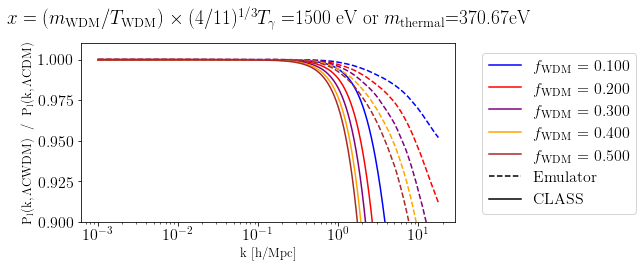

In [11]:
fig,ax = plt.subplots(1,1,figsize=(9,4))
start = 0
end = 850

for i in range(len(f_list)) :
    # plot CWDM_L /CDM_L 
    ax.plot(kk[start:end],pk_list_f[i][start:end] /pk_ref_lin[start:end], color=colors[i],
        label = r'$f_\mathrm{WDM}$'+r' = {a:.3f}'.format(a=f_list[i]),)    

    # plot CWDM_NL / CDM_NL
    # just plot "emulator"
    ax.plot(kk[start:end],emulator_list_f[i][start:end],color=colors[i],ls='--')
     
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_ylim(0.9,1.01)
    
ax.set_ylabel(r'$\mathrm{P_l(k,\Lambda CWDM) \ \ / \ \ P_l(k,\Lambda CDM)}$', fontsize=13)
ax.set_xlabel(r'k [h/Mpc]', fontsize=13)
ax.set_title(r'$x = (m_\mathrm{WDM}/T_\mathrm{WDM}) \times (4/11)^{1/3} T_\gamma =$'
             +r'{a} eV'.format(a=x) 
             +r' or $m_\mathrm{thermal}$='
             +r'{b}'.format(b=round(m_wdm.value,2)) 
             + str(m_wdm.unit), pad=20  )

handles,labels = ax.get_legend_handles_labels()

handles.append(Line2D([0],[0],ls='--',color='black')) 
handles.append(Line2D([0],[0],ls='-',color='black'))

labels.append('Emulator') 
labels.append('CLASS')

ax.legend(handles=handles,labels=labels,loc='lower left',bbox_to_anchor=(1.05,0.))

#ax.set_xlim(1e-1,1e0)
#ax.set_ylim(0.7,1.5e0)
plt.tight_layout()
#plt.savefig('ratio_of_pklin_varying_f_z' + str(z)+ '.png',dpi=300)

# Varying x

In [12]:
common_settings = { 'output':'mPk',
                    'P_k_max_h/Mpc':kmax,
                    'non linear':'halofit',
                    'YHe' : 0.24,
                    'z_max_pk' : z + 2 }

ref = Class()
ref.set(common_settings)
ref.set({'omega_cdm':omega_dm})
ref.compute()
ref.compute()

h = ref.h()
pk_ref_lin = np.vectorize(ref.pk_lin)(kk*h,z)
pk_ref_nl = np.vectorize(ref.pk)(kk*h,z)


# The following plots will have a fixed omega_DM, two fixed values of f_wdm and varying x
##########################################
f_list = [0.01,0.02]
x_list = np.geomspace(2,400,5)
##########################################

model = Class()
model.empty()

pk_list_x = [[],[]]
emulator_list_x = [[],[]]
m_list = []

for i in range(2) :
    for x in x_list :
        f_wdm = f_list[i]
        omega_wdm = omega_dm*f_wdm
        m_wdm = (omega_wdm*93.14)**0.25 * x**0.75 * u.eV
        if debug : print('Mass_class=',m_wdm)
        m_list.append(m_wdm)
        Twdm_over_Tgamma = (omega_wdm*93.14)**0.25 * x**-0.25 * (4./11.)**(1./3.)
        model.empty()
        model.set(common_settings)
        model.set({
            'N_ncdm':1,
            'm_ncdm':m_wdm.value,
            'T_ncdm':Twdm_over_Tgamma,
            'omega_cdm' :  omega_dm*(1.-f_wdm),
            'omega_ncdm' : omega_wdm,
                  })
        model.compute()
        h=model.h()
        pk_list_x[i].append(np.vectorize(model.pk_lin)(kk*h,z))
        
        # call emulator
        emulator_list_x[i].append(emulator(f_wdm,m_wdm,kk)[0])


Mass_class= 0.9726331938020203 eV
Mass_emulator =  0.0009726331938020203 keV
Mass_class= 2.6265895445738 eV
Mass_emulator =  0.0026265895445738 keV
Mass_class= 7.0930877946868485 eV
Mass_emulator =  0.007093087794686849 keV
Mass_class= 19.154836950856495 eV
Mass_emulator =  0.019154836950856496 keV
Mass_class= 51.72751123829784 eV
Mass_emulator =  0.051727511238297844 keV
Mass_class= 1.156662314357183 eV
Mass_emulator =  0.001156662314357183 keV
Mass_class= 3.1235589745989194 eV
Mass_emulator =  0.0031235589745989196 keV
Mass_class= 8.43515047278056 eV
Mass_emulator =  0.00843515047278056 keV
Mass_class= 22.779068388675572 eV
Mass_emulator =  0.022779068388675574 keV
Mass_class= 61.51472440596701 eV
Mass_emulator =  0.06151472440596701 keV


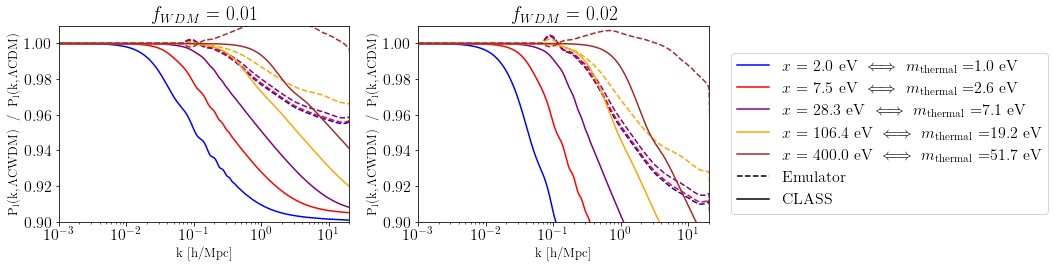

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,4))
start=0
end = -1
for i in range(2) :
    f_wdm = f_list[i]
    for j in range(len(x_list)) :
        # plot CWDM_L /CDM_L 
        ax[i].plot(kk[start:end],pk_list_x[i][j][start:end] /pk_ref_lin[start:end],color=colors[j],
                   label = r'$x$ = {a:1.1f} eV $\iff$'.format(a=x_list[j])
                   +r' $m_\mathrm{thermal}=$'
                   +r'{b:1.1f}'.format(b=m_list[j]))   

        # plot CWDM_NL / CDM_NL
        # just plot "emulator"
        ax[i].plot(kk[start:end],emulator_list_x[i][j][start:end],'--',color=colors[j])

        ax[i].set_xscale('log')
        ax[i].set_yscale('linear')
        ax[i].set_title(r'$f_{WDM}$ ' + '= {a}'.format(a=f_wdm))
        ax[i].set_ylabel(r'$\mathrm{P_l(k,\Lambda CWDM) \ \ / \ \ P_l(k,\Lambda CDM)}$', fontsize=13)
        ax[i].set_xlabel(r'k [h/Mpc]', fontsize=13)
        ax[i].set_xlim(1.e-3,20)
        ax[i].set_ylim(0.9,1.01)

        #ax[i].set_xlim(1e-1,1e1)
        #ax[i].set_yim()

handles,labels = ax[i].get_legend_handles_labels()
handles.append(Line2D([0],[0],ls='--',color='black')) 
handles.append(Line2D([0],[0],ls='-',color='black'))
#handles.append(Line2D([0],[0],ls=':',color='black'))
labels.append('Emulator') 
labels.append('CLASS')
#labels.append('Emulator * CDM_NL / CDM_Lin')
ax[1].legend(handles=handles,labels=labels,loc='lower left',bbox_to_anchor=(1.05,0.))
#fig.savefig('ratio_of_pklin_varying_x_z' + str(z)+ '.png',dpi=300)
plt.tight_layout()

In [14]:
# same with higher mass range
# same as previous cell with a fixed x and varying f_WDM

common_settings = { 'output':'mPk',
                    'P_k_max_h/Mpc':kmax,
                    'non linear':'halofit',
                    'YHe' : 0.24,
                    'z_max_pk' : z + 2 }

ref = Class()
ref.set(common_settings)
ref.set({'omega_cdm':omega_dm})
ref.compute()
ref.compute()

h = ref.h()
pk_ref_lin = np.vectorize(ref.pk_lin)(kk*h,z)
pk_ref_nl = np.vectorize(ref.pk)(kk*h,z)


# The following plots will have a fixed omega_DM, two fixed values of f_wdm and varying x

##################################################
f_list = [0.1,0.5]
x_list = np.geomspace(1e3,4e4,5)
##################################################

model = Class()
model.empty()

pk_list_x = [[],[]]
emulator_list_x = [[],[]]
m_list = []

for i in range(2) :
    for x in x_list :
        f_wdm = f_list[i]
        omega_wdm = omega_dm*f_wdm
        m_wdm = (omega_wdm*93.14)**0.25 * x**0.75 * u.eV
        if debug : print('Mass_class=',m_wdm)
        m_list.append(m_wdm)
        Twdm_over_Tgamma = (omega_wdm*93.14)**0.25 * x**-0.25 * (4./11.)**(1./3.)
        model.set(common_settings)
        model.set({
            'N_ncdm':1,
            'm_ncdm':m_wdm.value,
            'T_ncdm':Twdm_over_Tgamma,
            'YHe' : 0.24,
            'omega_cdm' :  omega_dm*(1.-f_wdm),
            'omega_ncdm' : omega_wdm
                  })
        model.compute()
        h=model.h()
        pk_list_x[i].append(np.vectorize(model.pk_lin)(kk*h,z))
        
        # call emulator
        emulator_list_x[i].append(emulator(f_wdm,m_wdm,kk)[0])


Mass_class= 182.88436985251874 eV
Mass_emulator =  0.18288436985251874 keV
Mass_class= 365.22696858008766 eV
Mass_emulator =  0.3652269685800877 keV
Mass_class= 729.3719998366673 eV
Mass_emulator =  0.7293719998366673 keV
Mass_class= 1456.583330124717 eV
Mass_emulator =  1.4565833301247169 keV
Mass_class= 2908.8517218543084 eV
Mass_emulator =  2.9088517218543086 keV
Mass_class= 273.4759195633749 eV
Mass_emulator =  0.27347591956337486 keV
Mass_class= 546.1417023353551 eV
Mass_emulator =  0.5461417023353552 keV
Mass_class= 1090.6655310126448 eV
Mass_emulator =  1.0906655310126447 keV
Mass_class= 2178.1001074491423 eV
Mass_emulator =  2.178100107449142 keV
Mass_emulator =  4.34974787702809 keV


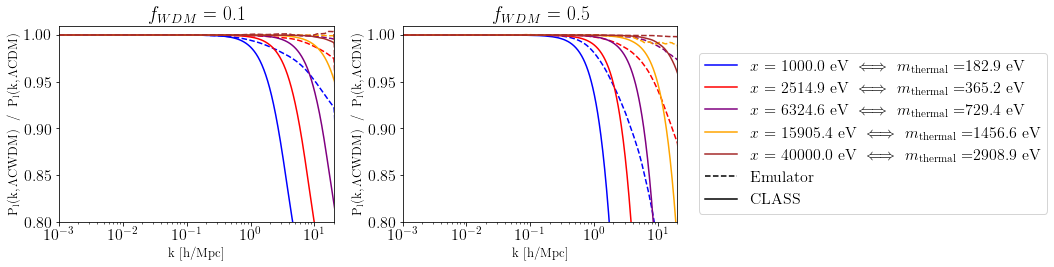

In [15]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,4))

start=0
end = -1
for i in range(2) :
    f_wdm = f_list[i]
    for j in range(len(x_list)) :
        
        # plot CWDM_L /CDM_L 
        ax[i].plot(kk[start:end],pk_list_x[i][j][start:end] /pk_ref_lin[start:end],color=colors[j],
                   label = r'$x$ = {a:1.1f} eV $\iff$'.format(a=x_list[j])
                   +r' $m_\mathrm{thermal}=$'
                   +r'{b:1.1f}'.format(b=m_list[j]))   

        # plot CWDM_NL / CDM_NL
        # just plot "emulator"
        ax[i].plot(kk[start:end],emulator_list_x[i][j][start:end],'--',color=colors[j])



        ax[i].set_xscale('log')
        ax[i].set_yscale('linear')
        ax[i].set_title(r'$f_{WDM}$ ' + '= {a}'.format(a=f_wdm))
        ax[i].set_ylabel(r'$\mathrm{P_l(k,\Lambda CWDM) \ \ / \ \ P_l(k,\Lambda CDM)}$', fontsize=13)
        ax[i].set_xlabel(r'k [h/Mpc]', fontsize=13)
        ax[i].set_xlim(1.e-3,20)
        ax[i].set_ylim(0.8,1.01)

        #ax[i].set_xlim(1e-1,1e1)
        #ax[i].set_yim()

handles,labels = ax[i].get_legend_handles_labels()

handles.append(Line2D([0],[0],ls='--',color='black')) 
handles.append(Line2D([0],[0],ls='-',color='black'))

labels.append('Emulator') 
labels.append('CLASS')

ax[1].legend(handles=handles,labels=labels,loc='lower left',bbox_to_anchor=(1.05,0.))

fig.savefig('ratio_of_pklin_varying_x_z' + str(z)+ '.png',dpi=300)
plt.tight_layout()